<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:11<00:00, 14.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), f'Weight_Epoch{epoch+1}.pth')
    scheduler.step()


Epoch 1: Loss: 1.0305, Train Accuracy: 64.79%
Test Accuracy: 73.56%
Confusion Matrix (Epoch 1):
[[837   8  23   4  19   1   2  23  54  29]
 [ 21 645   0   0   2   3   2   5 111 211]
 [ 79   2 579  25 144  48  34  58  17  14]
 [ 30   3  47 390 109 189  51 108  45  28]
 [ 11   2  19  10 831   7  19  88   7   6]
 [ 12   1  24  62  86 688   6  83  13  25]
 [  9   2  42  31  62  19 784  24  22   5]
 [ 13   1   9   9  46  25   3 859   5  30]
 [112   3   5   1   3   2   0   5 860   9]
 [ 39  14   4   1   3   0   0   9  47 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 1.0227, Train Accuracy: 65.96%
Test Accuracy: 69.34%
Confusion Matrix (Epoch 2):
[[718  33  53  18  19   3  14  13 102  27]
 [ 17 792  17  10   6   6  27   3  45  77]
 [ 91   4 598  69  70  44  81  32   7   4]
 [ 30   3 102 582  59 103  70  34  11   6]
 [ 30   1  63  76 652  19  73  77   9   0]
 [  6   0 106 213  47 531  29  56   9   3]
 [  6   2  39  86  24  12 824   5   2   0]
 [ 14   8  51  71  77  35  20 710   3  11]
 [ 67  49  15  19   7   3   4   1 810  25]
 [ 29 126  16  23   6   3  16  10  54 717]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.7733, Train Accuracy: 73.41%
Test Accuracy: 78.35%
Confusion Matrix (Epoch 3):
[[725  10  92  11  14   4  11  18  80  35]
 [ 10 850   9   1   1  14   6   6  33  70]
 [ 23   1 749  16  67  50  66  19   4   5]
 [ 12   0  81 547  61 166  63  49  12   9]
 [  4   1  56  24 764  38  71  30  12   0]
 [  6   0  59 103  41 727  14  47   1   2]
 [  2   2  34  32  17  13 891   7   2   0]
 [  5   2  37  20  47  57  14 811   1   6]
 [ 23  13  20  10   4   4   2   8 896  20]
 [ 16  39  10   6   0   6   5  19  24 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.6254, Train Accuracy: 78.43%
Test Accuracy: 79.61%
Confusion Matrix (Epoch 4):
[[897  10  16  10  14   3   3   3  27  17]
 [ 32 865   3   6   2   9   8   1  26  48]
 [ 75   1 655  45  85  63  42  22   7   5]
 [ 30   2  35 628  41 179  42  31   6   6]
 [ 10   1  25  44 836  33  23  26   1   1]
 [ 13   0  15 116  44 766   8  36   1   1]
 [  8   1  26  47  35  24 848   9   1   1]
 [ 22   1   9  24  69  59   6 794   2  14]
 [101  11   8   9   3   4   3   4 847  10]
 [ 56  64   3   7   0  12   8   6  19 825]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.5732, Train Accuracy: 80.45%
Test Accuracy: 81.60%
Confusion Matrix (Epoch 5):
[[824  10  20  12  13   4   3   3  54  57]
 [ 16 865   1   0   1   6   5   0  24  82]
 [ 59   2 701  11  92  80  27  15   8   5]
 [ 23   0  43 535  62 245  45  22   4  21]
 [  6   1  17  15 877  27  23  30   3   1]
 [  9   0  13  67  47 830   6  23   1   4]
 [  6   3  31  24  34  40 844   4   4  10]
 [ 15   3  12  11  43  59   9 833   1  14]
 [ 35   8   5   6   2   6   1   4 920  13]
 [ 13  28   1   3   0   2   2   1  19 931]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.5315, Train Accuracy: 81.77%
Test Accuracy: 82.74%
Confusion Matrix (Epoch 6):
[[823  34  13  11  12   2   8   5  66  26]
 [  4 942   2   7   1   4   1   2  12  25]
 [ 55   2 745  32  62  35  39  17  11   2]
 [ 15   5  36 677  61 107  39  41   6  13]
 [  4   2  21  20 863  12  22  51   4   1]
 [  9   2  24 128  39 721  13  56   3   5]
 [  3   4  24  44  26  14 871   9   3   2]
 [ 16   6  11  25  23  19   4 892   0   4]
 [ 30  34   4   8   2   1   1   5 903  12]
 [ 19 112   2   4   1   1   2   6  16 837]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.5054, Train Accuracy: 82.73%
Test Accuracy: 81.65%
Confusion Matrix (Epoch 7):
[[903   9  32   1   5   3   1   0  34  12]
 [ 18 927   4   1   1   3   0   1  23  22]
 [ 37   0 848  16  47  28  12   5   5   2]
 [ 42   5  67 614  50 172  25  13   5   7]
 [ 20   1  57  20 852  18  14  10   6   2]
 [ 17   2  51  95  38 773   2  15   5   2]
 [ 17   2  78  48  27  27 789   3   5   4]
 [ 55   4  31  29  62  65   0 747   1   6]
 [ 58  13  10   7   1   2   0   1 896  12]
 [ 50 100   6   2   3   1   0   2  20 816]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.4734, Train Accuracy: 83.61%
Test Accuracy: 82.22%
Confusion Matrix (Epoch 8):
[[708  15  18  29  16  12   5  19 148  30]
 [  4 931   0   1   1   3   3   1  23  33]
 [ 27   0 723  32  42  92  42  25  14   3]
 [  7   5  23 615  31 220  51  34   9   5]
 [  6   2  25  37 788  45  34  58   4   1]
 [  4   1   7  65  17 865  15  21   4   1]
 [  3   3  13  30  16  27 897   5   6   0]
 [  2   2   7  20  15  60   3 882   3   6]
 [  9  15   2   7   4   8   0   2 949   4]
 [ 11  65   2   5   0   3   3  12  35 864]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.4556, Train Accuracy: 84.21%
Test Accuracy: 83.41%
Confusion Matrix (Epoch 9):
[[882   7  26  19   4   3   4   2  25  28]
 [ 14 849   0   2   1   3   6   1  16 108]
 [ 40   3 816  23  24  46  31  11   2   4]
 [ 11   8  59 638  33 165  54  16   5  11]
 [ 15   1  85  28 786  31  19  30   5   0]
 [  6   0  30  95  19 800  18  23   1   8]
 [  4   1  37  35  16  17 889   0   1   0]
 [  8   2  12  27  23  41   5 869   3  10]
 [ 66   7   8  11   1   4   0   1 879  23]
 [ 25  16   2   6   0   2   3   0  13 933]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.4499, Train Accuracy: 84.60%
Test Accuracy: 83.58%
Confusion Matrix (Epoch 10):
[[796  10  26  14  18   4   8  11  56  57]
 [  5 856   0   4   1   2   6   3  12 111]
 [ 32   1 673  29 112  59  60  21   6   7]
 [  8   4  19 663  57 136  65  33   7   8]
 [  5   1   8  18 892  15  28  32   1   0]
 [  5   0   9  93  43 794  19  32   2   3]
 [  2   1  11  15  20  11 933   3   2   2]
 [  3   3   3  20  32  21   8 899   1  10]
 [ 29  14   6   5   5   2   2   2 910  25]
 [  3  23   2   6   2   0   5   3  14 942]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.3355, Train Accuracy: 88.43%
Test Accuracy: 87.17%
Confusion Matrix (Epoch 11):
[[902   9  18   5   5   0   2   4  39  16]
 [ 14 940   0   3   1   2   2   0   6  32]
 [ 36   0 845  26  34  16  25  12   2   4]
 [ 14   1  34 747  44  89  37  23   6   5]
 [  5   1  31  24 875  13  24  23   4   0]
 [  7   0  30 140  27 760  12  21   1   2]
 [  5   0  26  28  11   5 920   2   2   1]
 [ 10   2  12  19  25  23   2 901   1   5]
 [ 40  13   3   6   2   0   0   0 926  10]
 [ 20  51   2   4   0   1   3   3  15 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.2930, Train Accuracy: 89.65%
Test Accuracy: 87.39%
Confusion Matrix (Epoch 12):
[[914   9  17   6  10   0   3   4  23  14]
 [ 12 940   0   3   1   2   1   0   4  37]
 [ 34   0 807  27  51  25  36  14   1   5]
 [ 12   1  25 723  44 112  41  29   5   8]
 [  6   1  25  19 887  14  21  25   2   0]
 [  4   0  21 124  29 781  16  23   0   2]
 [  5   0  15  22  14   7 930   4   2   1]
 [  4   2   6  12  24  32   2 914   0   4]
 [ 43  12   4   5   2   1   0   2 921  10]
 [ 16  36   2   4   0   3   2   3  12 922]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.2789, Train Accuracy: 90.32%
Test Accuracy: 87.44%
Confusion Matrix (Epoch 13):
[[906   8  21   5   9   0   4   3  26  18]
 [  9 918   1   4   0   1   2   0   7  58]
 [ 24   1 833  29  51  21  23  12   1   5]
 [ 12   1  30 751  45  95  31  25   5   5]
 [  5   1  25  17 895  15  19  20   2   1]
 [  5   0  20 148  31 761  12  21   0   2]
 [  5   0  23  28  13   5 919   4   2   1]
 [  4   0   6  21  30  26   1 906   1   5]
 [ 38  12   4   5   2   1   0   2 921  15]
 [ 13  30   2   5   0   1   1   2  12 934]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.2689, Train Accuracy: 90.64%
Test Accuracy: 87.63%
Confusion Matrix (Epoch 14):
[[896  10  25   6  13   1   3   2  29  15]
 [  9 946   0   1   0   2   2   0   6  34]
 [ 16   0 844  25  48  24  25  11   3   4]
 [ 11   1  29 724  49 106  42  23   6   9]
 [  6   1  27  15 892  12  19  26   2   0]
 [  3   0  20 133  29 777  14  21   1   2]
 [  5   0  21  22  15   8 924   3   2   0]
 [  7   1   6  15  26  30   3 907   1   4]
 [ 32  14   4   4   2   1   0   0 932  11]
 [ 15  41   1   3   0   1   2   3  13 921]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.2563, Train Accuracy: 91.06%
Test Accuracy: 87.47%
Confusion Matrix (Epoch 15):
[[905  10  15   5   9   0   3   2  33  18]
 [  8 933   2   3   0   2   2   0   8  42]
 [ 32   0 840  30  41  18  25   8   3   3]
 [ 15   1  29 746  41  93  39  23   6   7]
 [  8   1  23  20 874  15  30  25   4   0]
 [  3   0  21 153  27 757  13  23   0   3]
 [  6   1  24  21  10   3 932   2   1   0]
 [  9   0   8  17  26  25   5 905   1   4]
 [ 36  13   2   4   3   1   1   2 929   9]
 [ 14  32   2   4   0   1   2   2  17 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.2429, Train Accuracy: 91.54%
Test Accuracy: 87.94%
Confusion Matrix (Epoch 16):
[[916   6  18   6   8   0   3   4  29  10]
 [ 10 925   2   3   0   3   2   0  15  40]
 [ 27   1 853  25  36  30  19   8   1   0]
 [ 10   1  33 749  36 110  31  21   5   4]
 [  6   1  31  19 880  26  16  18   3   0]
 [  3   0  17 126  25 804   8  15   0   2]
 [  5   0  28  29  12  14 907   3   2   0]
 [ 10   0   5  19  21  33   2 905   1   4]
 [ 36   9   3   7   2   2   1   1 931   8]
 [ 18  27   4   6   0   1   1   2  17 924]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.2366, Train Accuracy: 91.73%
Test Accuracy: 87.79%
Confusion Matrix (Epoch 17):
[[903  13  18   7  11   0   4   2  29  13]
 [  7 935   1   3   0   2   2   0  10  40]
 [ 25   2 853  18  49  15  26   8   3   1]
 [ 11   1  33 729  42 113  40  22   4   5]
 [  3   1  26  18 891  20  18  22   1   0]
 [  4   0  23 117  29 789  14  22   0   2]
 [  5   1  25  20  12   4 931   1   1   0]
 [  6   0   9  24  24  35   5 894   0   3]
 [ 34  11   7   2   3   1   1   1 926  14]
 [ 15  32   4   4   0   2   2   2  11 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.2247, Train Accuracy: 92.17%
Test Accuracy: 88.00%
Confusion Matrix (Epoch 18):
[[904   7  14  11  12   2   3   3  32  12]
 [  8 939   0   2   0   2   1   1   8  39]
 [ 23   2 850  23  41  26  23   8   3   1]
 [ 10   1  30 755  34 103  31  25   5   6]
 [  5   1  26  23 885  25  19  14   2   0]
 [  4   0  13 139  24 788  10  20   0   2]
 [  5   1  22  29  11   7 921   3   1   0]
 [  4   0  10  20  30  35   2 896   0   3]
 [ 33  11   4   5   2   1   0   1 936   7]
 [ 13  34   2   5   0   2   1   3  14 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.2208, Train Accuracy: 92.27%
Test Accuracy: 88.15%
Confusion Matrix (Epoch 19):
[[912   8  21   9  10   1   3   2  22  12]
 [  9 937   1   3   0   2   2   0  11  35]
 [ 21   1 852  26  45  20  22  11   2   0]
 [ 10   1  25 769  35 102  28  20   5   5]
 [  4   1  23  21 894  23  13  19   2   0]
 [  3   0  15 140  24 785  10  19   2   2]
 [  6   0  23  37  14   7 910   3   0   0]
 [  3   0   7  19  28  37   4 899   0   3]
 [ 38  10   4   4   2   2   1   3 925  11]
 [ 16  29   3   5   0   1   0   3  11 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.2106, Train Accuracy: 92.54%
Test Accuracy: 88.22%
Confusion Matrix (Epoch 20):
[[907   8  13   9  10   3   4   3  28  15]
 [ 10 933   0   2   0   4   1   0  14  36]
 [ 30   2 843  23  42  21  24  12   2   1]
 [  8   1  27 761  32 106  31  23   5   6]
 [  3   1  26  25 887  17  21  18   2   0]
 [  5   0  14 132  28 784  15  19   0   3]
 [  6   0  18  28  12   6 924   3   2   1]
 [  3   0   8  20  26  25   4 911   0   3]
 [ 34   7   3   4   2   1   1   2 936  10]
 [ 14  29   3   3   0   1   0   2  12 936]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.1982, Train Accuracy: 93.03%
Test Accuracy: 88.50%
Confusion Matrix (Epoch 21):
[[904   8  17   7  12   2   5   3  31  11]
 [  9 947   1   1   0   2   1   0  11  28]
 [ 25   2 860  16  38  18  25  13   2   1]
 [ 11   1  31 736  39 109  34  27   6   6]
 [  4   1  21  18 894  20  19  21   2   0]
 [  6   0  16 116  27 795  15  22   0   3]
 [  6   1  19  21  12   7 930   3   0   1]
 [  4   0   7  17  22  29   2 916   0   3]
 [ 32  10   5   2   2   2   0   1 938   8]
 [ 16  35   2   3   0   1   0   2  11 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.1924, Train Accuracy: 93.19%
Test Accuracy: 88.42%
Confusion Matrix (Epoch 22):
[[913   6  17   7  12   2   5   3  23  12]
 [ 10 936   1   2   0   2   1   0  11  37]
 [ 29   2 848  21  40  19  26  13   2   0]
 [  9   1  27 750  37 105  33  27   5   6]
 [  3   1  22  18 894  20  19  21   2   0]
 [  6   0  12 123  28 791  15  22   0   3]
 [  6   1  17  23  11   6 932   3   0   1]
 [  4   0   7  16  22  31   3 914   0   3]
 [ 35  10   4   3   2   1   1   3 930  11]
 [ 16  31   2   3   0   1   0   2  11 934]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.1907, Train Accuracy: 93.34%
Test Accuracy: 88.47%
Confusion Matrix (Epoch 23):
[[902   9  18   9  13   2   4   2  31  10]
 [  8 943   1   3   0   2   1   1  11  30]
 [ 25   2 857  22  37  19  24  13   1   0]
 [  8   1  28 766  32  99  33  25   4   4]
 [  3   1  22  19 893  20  19  21   2   0]
 [  4   0  14 130  28 789  14  18   0   3]
 [  6   1  20  25  11   6 928   3   0   0]
 [  5   0   7  19  24  32   4 906   0   3]
 [ 31  11   5   4   2   1   1   2 936   7]
 [ 15  36   2   5   0   1   1   2  11 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.1859, Train Accuracy: 93.45%
Test Accuracy: 88.56%
Confusion Matrix (Epoch 24):
[[917   6  18   7  10   1   3   2  26  10]
 [ 11 938   1   2   0   3   1   0  11  33]
 [ 25   1 864  19  40  19  21   9   2   0]
 [  9   1  30 762  39 101  27  21   6   4]
 [  4   1  22  20 897  18  18  18   2   0]
 [  6   0  17 127  28 792  10  17   0   3]
 [  6   1  22  25  11   6 925   3   0   1]
 [  7   0   8  18  31  28   4 901   0   3]
 [ 35  10   5   4   2   1   1   0 934   8]
 [ 17  34   2   5   0   1   1   2  12 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.1852, Train Accuracy: 93.48%
Test Accuracy: 88.63%
Confusion Matrix (Epoch 25):
[[913   7  17   7  11   1   4   2  28  10]
 [  9 943   1   1   0   2   1   0  11  32]
 [ 26   2 866  18  36  15  23  12   2   0]
 [  8   1  30 754  34  99  38  27   4   5]
 [  4   1  26  19 888  20  20  20   2   0]
 [  7   0  19 120  27 790  14  20   0   3]
 [  6   1  23  19   9   6 933   3   0   0]
 [  5   0   8  17  24  29   4 910   0   3]
 [ 33  10   5   2   2   1   1   2 937   7]
 [ 16  34   2   4   0   1   1   2  11 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.1868, Train Accuracy: 93.46%
Test Accuracy: 88.50%
Confusion Matrix (Epoch 26):
[[915   6  17   7  10   1   3   2  29  10]
 [ 12 932   1   2   0   3   2   1  15  32]
 [ 27   1 859  20  38  19  21  12   3   0]
 [ 12   1  29 761  36  99  28  25   4   5]
 [  4   1  23  22 890  22  17  19   2   0]
 [  7   0  18 119  27 799   7  20   0   3]
 [  6   1  23  31  13   6 915   3   1   1]
 [  6   0   8  16  24  30   2 911   0   3]
 [ 30   9   5   2   2   2   0   2 941   7]
 [ 17  33   2   5   0   1   0   2  13 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.1842, Train Accuracy: 93.58%
Test Accuracy: 88.47%
Confusion Matrix (Epoch 27):
[[922   6  17   6  10   1   3   2  23  10]
 [ 12 936   1   3   0   3   1   0  11  33]
 [ 29   1 858  20  38  19  21  11   3   0]
 [ 11   1  30 760  38  99  29  22   5   5]
 [  5   1  24  19 888  25  18  18   2   0]
 [  7   0  16 123  27 796   9  19   0   3]
 [  6   1  22  28  12   7 920   3   0   1]
 [  8   0   8  17  24  32   2 906   0   3]
 [ 38   7   5   3   2   1   1   1 932  10]
 [ 17  32   2   5   0   1   0   2  12 929]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.1796, Train Accuracy: 93.68%
Test Accuracy: 88.61%
Confusion Matrix (Epoch 28):
[[910   6  19   7  10   1   3   2  30  12]
 [ 10 938   1   2   0   2   1   1  11  34]
 [ 24   1 862  17  39  21  24  10   2   0]
 [ 11   1  31 744  39 108  34  22   5   5]
 [  5   1  24  18 892  24  17  17   2   0]
 [  5   0  18 109  25 810  10  19   1   3]
 [  6   1  24  22  12   5 926   3   0   1]
 [  5   0   8  14  25  37   2 906   0   3]
 [ 29   9   5   2   2   1   1   2 941   8]
 [ 15  32   2   4   0   1   0   2  12 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.1822, Train Accuracy: 93.61%
Test Accuracy: 88.54%
Confusion Matrix (Epoch 29):
[[915   6  19   7  11   1   3   2  26  10]
 [ 10 938   1   2   0   3   1   0  11  34]
 [ 28   1 861  22  38  18  20   9   3   0]
 [ 10   1  30 773  36  96  25  21   4   4]
 [  5   1  26  19 895  21  13  18   2   0]
 [  6   0  16 134  27 786   7  21   1   2]
 [  6   1  24  29  14   6 915   3   1   1]
 [  7   0   9  18  23  32   1 907   0   3]
 [ 32  10   6   3   2   1   1   2 934   9]
 [ 16  32   2   5   0   1   0   2  12 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.1837, Train Accuracy: 93.62%
Test Accuracy: 88.72%
Confusion Matrix (Epoch 30):
[[909   6  18  10   9   1   4   2  29  12]
 [  9 935   0   3   0   3   1   0  11  38]
 [ 22   2 848  28  39  20  26  11   3   1]
 [  8   1  23 777  32  99  31  21   4   4]
 [  4   1  20  22 890  23  19  19   2   0]
 [  4   0  14 128  24 800   8  19   1   2]
 [  5   1  20  26   9   6 930   3   0   0]
 [  5   0   8  16  23  34   3 908   0   3]
 [ 28  11   4   2   2   2   0   3 936  12]
 [ 15  27   2   4   0   1   0   1  11 939]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.1818, Train Accuracy: 93.57%
Test Accuracy: 88.67%
Confusion Matrix (Epoch 31):
[[912   6  19   7  11   1   3   2  27  12]
 [ 10 939   1   1   0   2   1   0  11  35]
 [ 22   2 867  24  36  18  21   8   2   0]
 [  9   1  30 769  36  97  28  21   4   5]
 [  3   1  26  19 894  22  16  17   2   0]
 [  4   0  19 129  28 791   8  18   1   2]
 [  6   1  23  27  12   6 920   3   1   1]
 [  7   0  10  17  26  31   2 904   0   3]
 [ 33  10   4   2   2   2   0   2 935  10]
 [ 16  29   2   4   0   1   0   1  11 936]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.1769, Train Accuracy: 93.88%
Test Accuracy: 88.60%
Confusion Matrix (Epoch 32):
[[914   6  20   7  10   1   3   2  27  10]
 [ 10 943   1   1   0   2   1   0  12  30]
 [ 26   1 870  18  35  15  24   8   3   0]
 [ 10   1  31 755  37  99  39  20   4   4]
 [  5   1  27  17 892  21  19  16   2   0]
 [  6   0  22 122  27 788  15  17   1   2]
 [  6   1  23  22  10   4 931   3   0   0]
 [  5   0   9  17  27  33   4 902   0   3]
 [ 32  10   4   2   2   1   1   3 935  10]
 [ 16  32   2   5   0   1   1   1  12 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.1780, Train Accuracy: 93.75%
Test Accuracy: 88.69%
Confusion Matrix (Epoch 33):
[[911   6  19   8  10   1   4   2  28  11]
 [  9 936   1   3   0   2   1   0  10  38]
 [ 23   2 860  24  38  19  22   9   2   1]
 [  9   1  26 769  32 100  34  21   4   4]
 [  3   1  23  21 891  24  19  16   2   0]
 [  5   0  17 122  28 801   8  17   0   2]
 [  5   1  22  28  10   6 925   3   0   0]
 [  6   0   8  16  24  35   3 905   0   3]
 [ 33  10   4   2   2   2   0   3 934  10]
 [ 15  29   2   4   0   1   0   1  11 937]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.1794, Train Accuracy: 93.74%
Test Accuracy: 88.62%
Confusion Matrix (Epoch 34):
[[913   6  17   8  11   1   4   2  27  11]
 [  9 944   1   2   0   2   1   0  10  31]
 [ 29   2 854  23  39  19  23   9   2   0]
 [  9   1  27 768  35  98  33  21   4   4]
 [  3   1  23  20 892  23  19  17   2   0]
 [  5   0  17 126  28 793  10  18   1   2]
 [  5   1  22  27  11   6 925   3   0   0]
 [  5   0   8  17  25  32   3 907   0   3]
 [ 33  10   4   3   2   1   1   3 934   9]
 [ 15  32   2   5   0   1   1   1  11 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.1788, Train Accuracy: 93.68%
Test Accuracy: 88.73%
Confusion Matrix (Epoch 35):
[[910   7  18   8  10   1   4   2  29  11]
 [  9 942   1   2   0   2   1   0  12  31]
 [ 24   2 869  19  36  19  21   8   2   0]
 [  9   1  31 757  33 107  34  18   5   5]
 [  4   1  26  20 888  24  18  17   2   0]
 [  4   0  20 120  24 804   8  17   1   2]
 [  5   1  23  24  10   6 928   3   0   0]
 [  6   0   8  16  23  36   3 904   1   3]
 [ 27  10   5   2   2   1   1   2 941   9]
 [ 15  34   2   4   0   1   1   1  12 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.1776, Train Accuracy: 93.84%
Test Accuracy: 88.59%
Confusion Matrix (Epoch 36):
[[910   6  18   8  12   1   4   2  28  11]
 [  9 939   1   3   0   2   1   0  11  34]
 [ 26   1 855  23  39  20  24   9   3   0]
 [  9   1  27 766  35  99  34  21   4   4]
 [  4   1  23  19 893  21  19  18   2   0]
 [  4   0  15 125  29 796  11  17   1   2]
 [  5   1  23  24  10   6 928   3   0   0]
 [  5   0   8  16  25  35   3 905   0   3]
 [ 32  10   4   2   2   1   1   3 935  10]
 [ 15  31   2   5   0   1   1   1  12 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.1790, Train Accuracy: 93.74%
Test Accuracy: 88.64%
Confusion Matrix (Epoch 37):
[[913   6  18   7  10   1   4   2  28  11]
 [ 10 932   1   2   0   2   1   1  13  38]
 [ 28   1 858  19  38  21  22  10   3   0]
 [ 10   1  30 754  38 102  35  22   4   4]
 [  4   1  22  17 895  24  17  18   2   0]
 [  4   0  17 120  28 802   8  18   1   2]
 [  6   1  23  24  12   6 925   3   0   0]
 [  5   0   8  16  25  32   3 908   0   3]
 [ 29   9   4   2   2   2   0   3 939  10]
 [ 15  26   2   4   0   1   0   2  12 938]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.1761, Train Accuracy: 93.73%
Test Accuracy: 88.54%
Confusion Matrix (Epoch 38):
[[916   6  17   8  11   1   3   2  26  10]
 [  9 940   1   3   0   2   2   0  13  30]
 [ 27   1 856  21  40  19  25   9   2   0]
 [  9   1  28 759  37  98  38  22   4   4]
 [  3   1  21  19 899  19  18  18   2   0]
 [  5   0  16 129  29 785  14  19   1   2]
 [  6   1  20  25  10   5 930   3   0   0]
 [  5   0   8  16  27  31   4 906   0   3]
 [ 35  10   4   2   2   1   1   3 935   7]
 [ 17  33   2   5   0   1   1   1  12 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.1745, Train Accuracy: 93.89%
Test Accuracy: 88.63%
Confusion Matrix (Epoch 39):
[[916   6  19   7  10   1   3   2  26  10]
 [ 10 936   1   1   0   2   1   1  11  37]
 [ 28   1 864  18  36  18  21  12   2   0]
 [ 11   1  31 751  37 100  34  24   4   7]
 [  4   1  25  17 891  22  17  22   1   0]
 [  7   0  20 118  26 796   9  21   0   3]
 [  6   1  23  25  11   6 925   3   0   0]
 [  5   0   9  15  22  29   3 914   0   3]
 [ 33  10   4   2   2   1   1   2 934  11]
 [ 15  28   2   4   0   1   0   2  12 936]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.1753, Train Accuracy: 93.82%
Test Accuracy: 88.53%
Confusion Matrix (Epoch 40):
[[919   6  16   7  11   0   4   2  25  10]
 [  9 935   1   3   0   3   2   1  12  34]
 [ 27   1 860  21  38  19  23   9   2   0]
 [  9   1  29 761  39  97  34  22   4   4]
 [  4   1  25  17 895  20  18  18   2   0]
 [  4   0  21 126  29 789  11  18   0   2]
 [  6   1  23  25  10   6 926   3   0   0]
 [  5   0   8  17  25  32   3 907   0   3]
 [ 35  10   4   3   2   1   1   2 931  11]
 [ 18  29   2   5   0   1   1   2  12 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.1741, Train Accuracy: 93.89%
Test Accuracy: 88.65%
Confusion Matrix (Epoch 41):
[[914   6  19   7  11   1   3   2  27  10]
 [  9 943   1   3   0   2   1   0  12  29]
 [ 28   1 861  22  37  20  21   7   3   0]
 [  9   1  25 780  36  95  28  18   4   4]
 [  5   1  25  20 891  21  18  17   2   0]
 [  4   0  18 136  29 786   8  16   1   2]
 [  6   1  23  28  11   6 922   3   0   0]
 [  7   0   8  20  27  30   3 902   0   3]
 [ 30  10   5   2   2   1   1   2 939   8]
 [ 16  35   2   5   0   1   1   1  12 927]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.1771, Train Accuracy: 93.88%
Test Accuracy: 88.62%
Confusion Matrix (Epoch 42):
[[911   7  18   7  10   1   4   2  30  10]
 [ 10 940   1   1   0   2   1   0  15  30]
 [ 27   1 865  18  36  18  23   9   3   0]
 [ 10   1  29 749  32 104  39  24   7   5]
 [  5   1  26  20 882  24  19  20   3   0]
 [  5   0  18 119  24 798  11  21   1   3]
 [  6   1  23  23   9   6 929   3   0   0]
 [  5   0   9  15  21  34   3 910   0   3]
 [ 23   9   4   2   2   1   1   3 948   7]
 [ 15  31   2   5   0   1   1   2  13 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.1765, Train Accuracy: 93.80%
Test Accuracy: 88.57%
Confusion Matrix (Epoch 43):
[[914   6  20   7  10   0   3   2  28  10]
 [ 10 937   1   1   0   2   1   0  13  35]
 [ 24   1 870  19  36  18  22   8   2   0]
 [ 12   1  31 749  36 100  37  24   4   6]
 [  5   1  26  19 892  21  17  17   2   0]
 [  6   0  22 120  27 792  10  19   1   3]
 [  6   1  23  24  10   6 927   3   0   0]
 [  6   0   9  16  25  30   3 908   0   3]
 [ 32  10   4   2   2   1   1   2 936  10]
 [ 17  29   2   4   0   1   1   2  12 932]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.1764, Train Accuracy: 93.79%
Test Accuracy: 88.61%
Confusion Matrix (Epoch 44):
[[912   6  19   7  11   1   4   2  26  12]
 [  9 939   1   2   0   2   1   0  10  36]
 [ 22   2 876  18  34  15  21   9   2   1]
 [  9   1  32 759  34  99  34  23   4   5]
 [  4   1  34  19 884  22  17  18   1   0]
 [  3   0  24 121  27 793  10  19   1   2]
 [  6   1  25  24   9   6 926   3   0   0]
 [  5   0  10  17  23  33   2 907   0   3]
 [ 35  10   4   2   2   1   1   3 930  12]
 [ 15  30   2   4   0   1   1   1  11 935]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.1752, Train Accuracy: 93.87%
Test Accuracy: 88.59%
Confusion Matrix (Epoch 45):
[[916   7  17   7  11   0   3   2  27  10]
 [ 10 940   1   1   0   2   1   0  12  33]
 [ 26   1 867  19  37  17  22   8   2   1]
 [ 12   1  30 752  37  99  39  21   4   5]
 [  5   1  25  16 894  21  19  17   2   0]
 [  6   0  21 124  28 786  14  17   1   3]
 [  6   1  23  24  10   5 928   3   0   0]
 [  7   0   9  17  26  29   3 906   0   3]
 [ 31  10   5   2   2   1   1   1 937  10]
 [ 15  31   2   4   0   1   1   1  12 933]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.1794, Train Accuracy: 93.61%
Test Accuracy: 88.67%
Confusion Matrix (Epoch 46):
[[916   6  18   7  11   1   3   2  25  11]
 [  9 939   1   2   0   2   1   0  11  35]
 [ 27   2 858  22  38  19  21  11   2   0]
 [  9   1  26 763  34 102  33  23   4   5]
 [  4   1  22  20 887  24  16  25   1   0]
 [  6   0  17 120  25 798   9  22   0   3]
 [  6   1  22  26  10   6 926   3   0   0]
 [  5   0   8  16  20  32   2 914   0   3]
 [ 35  10   3   2   2   1   1   4 931  11]
 [ 15  30   2   4   0   1   0   2  11 935]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.1776, Train Accuracy: 93.75%
Test Accuracy: 88.60%
Confusion Matrix (Epoch 47):
[[918   6  18   6  11   1   3   2  25  10]
 [ 10 935   1   1   0   2   1   1  13  36]
 [ 26   1 870  16  36  18  19  12   2   0]
 [ 14   1  34 743  38 111  26  24   4   5]
 [  5   1  25  18 895  23  13  18   2   0]
 [  5   0  20 109  25 810   7  20   1   3]
 [  6   1  28  28  14   8 910   3   1   1]
 [  5   0   9  15  24  32   1 911   0   3]
 [ 33  10   4   2   2   2   0   3 935   9]
 [ 16  30   2   4   0   1   0   2  12 933]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.1791, Train Accuracy: 93.82%
Test Accuracy: 88.50%
Confusion Matrix (Epoch 48):
[[913   6  15   8  12   1   4   2  27  12]
 [  9 936   1   2   0   2   1   0  12  37]
 [ 29   2 842  26  40  19  27  11   3   1]
 [  9   1  24 766  36  95  37  23   4   5]
 [  4   1  20  19 895  21  20  18   2   0]
 [  4   0  13 132  27 785  16  20   1   2]
 [  5   1  20  24  10   5 932   3   0   0]
 [  5   0   8  17  25  30   3 909   0   3]
 [ 29   9   3   2   2   1   1   4 938  11]
 [ 15  29   2   4   0   1   1   2  12 934]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.1719, Train Accuracy: 93.97%
Test Accuracy: 88.63%
Confusion Matrix (Epoch 49):
[[917   6  16   7  12   0   3   2  27  10]
 [ 10 945   1   1   0   2   1   0  10  30]
 [ 26   2 865  18  38  17  22   9   3   0]
 [ 10   1  30 761  36  95  34  24   4   5]
 [  3   1  23  18 897  23  16  17   2   0]
 [  6   0  20 130  28 783  10  19   1   3]
 [  6   1  23  26  12   6 923   3   0   0]
 [  5   0   8  19  25  28   3 909   0   3]
 [ 33  10   4   2   2   1   1   2 935  10]
 [ 15  36   2   4   0   1   1   1  12 928]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.1776, Train Accuracy: 93.78%
Test Accuracy: 88.51%
Confusion Matrix (Epoch 50):
[[912   6  16   8  12   1   4   2  26  13]
 [  9 939   1   2   0   2   1   0  10  36]
 [ 26   2 850  22  41  19  25  10   3   2]
 [  9   1  25 760  38  96  37  23   4   7]
 [  3   1  22  18 899  20  18  17   2   0]
 [  5   0  14 132  28 784  13  21   1   2]
 [  5   1  21  24  10   5 931   3   0   0]
 [  6   0   8  19  25  28   3 908   0   3]
 [ 33  10   4   2   2   1   1   2 932  13]
 [ 15  29   2   4   0   1   1   1  11 936]]


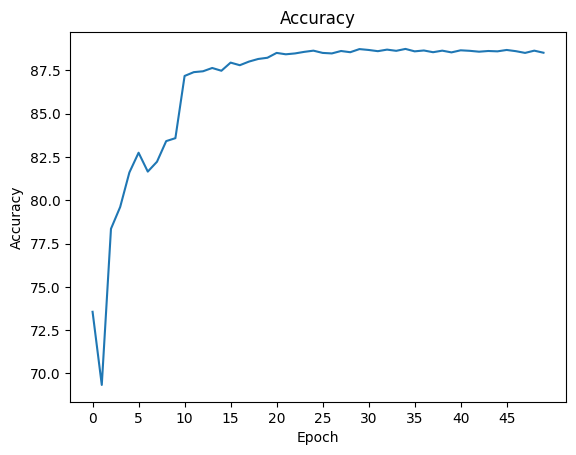

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()